In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

import cv2
import os
import random

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import shutil

We're using TF 2.16.1
We are using Keras 3.3.2


In [5]:
def load_class_names(file_path):
    with open(file_path, 'r') as file:
        class_names = [line.strip() for line in file.readlines()]
    return class_names

def load_image(image_path):
    return cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

def load_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
    return labels

def plot_image_with_labels(image, labels, class_names, image_id):
    plt.imshow(image)
    plt.title(f'Image ID: {image_id}')
    height, width, _ = image.shape
    for label in labels:
        class_id, x_center, y_center, bbox_width, bbox_height = map(float, label)
        x_center *= width
        y_center *= height
        bbox_width *= width
        bbox_height *= height
        x_min = x_center - bbox_width / 2
        y_min = y_center - bbox_height / 2
        rect = plt.Rectangle((x_min, y_min), bbox_width, bbox_height, edgecolor='r', facecolor='none')
        plt.gca().add_patch(rect)
        
        # Добавление текста с именем класса
        class_name = class_names[int(class_id)]
        plt.text(x_min, y_min - 10, class_name, color='red', fontsize=12, bbox=dict(facecolor='white', alpha=0.5))
    
    plt.show()

In [6]:
# Путь к директории с изображениями и файлами разметки
data_dir = 'dataset/'

# Путь к файлу с именами классов
class_names_file = 'dataset/classes.txt'

# Загрузка имен классов
class_names = load_class_names(class_names_file)

# Получение всех файлов из директории
files = os.listdir(data_dir)

# Фильтрация изображений и файлов разметки
image_files = [f for f in files if f.endswith(('.jpg', '.png', '.jpeg'))]
label_files = [f for f in files if f.endswith('.txt')]


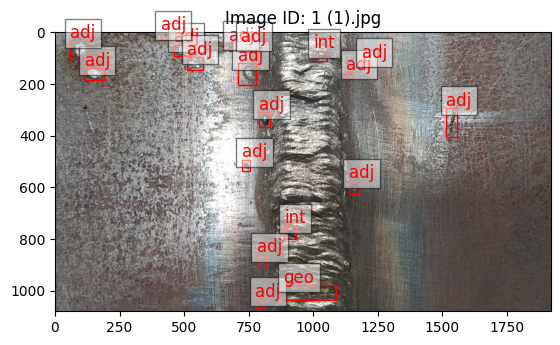

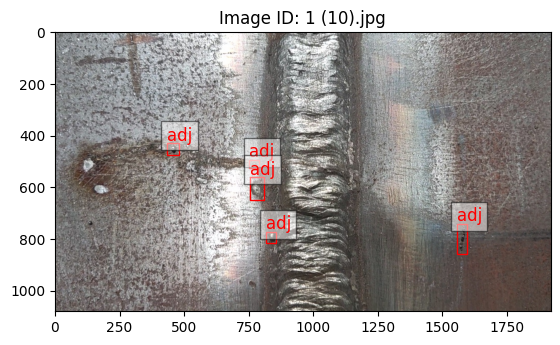

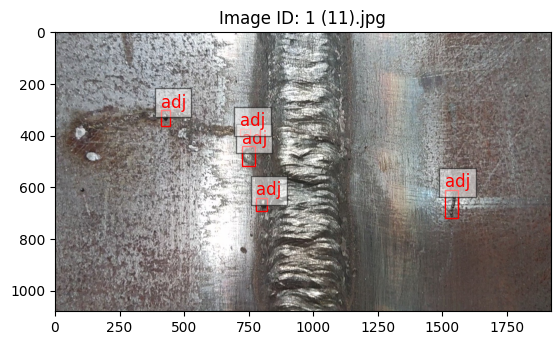

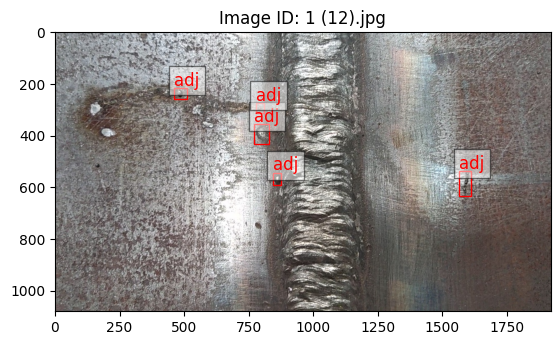

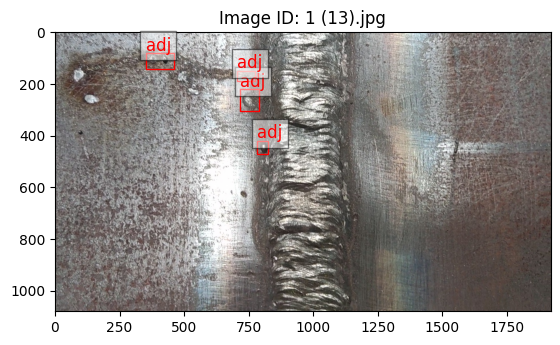

In [7]:
# Пример загрузки и отображения одного изображения и его разметки
counter = 0
for image_file in image_files:
    image_path = os.path.join(data_dir, image_file)
    label_path = os.path.join(data_dir, os.path.splitext(image_file)[0] + '.txt')

    if os.path.exists(label_path):
        image = load_image(image_path)
        if image is not None:
            labels = load_labels(label_path)
            plot_image_with_labels(image, labels, class_names, image_file)
            counter += 1
            if counter >= 5:
                break
    else:
        print(f"No label file found for image {image_file}")

In [6]:
from sklearn.model_selection import train_test_split

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def copy_files(files, src_dir, dst_dir):
    create_dir(dst_dir)
    for file in files:
        shutil.copy(os.path.join(src_dir, file), os.path.join(dst_dir, file))

In [4]:
# Путь к директории с изображениями и файлами разметки
data_dir = 'dataset/'
image_files = [f for f in os.listdir(data_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

In [7]:
# Разделение данных на train, valid и test
train_files, test_files = train_test_split(image_files, test_size=0.2, random_state=42)
train_files, valid_files = train_test_split(train_files, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Создание директорий для разделенных данных
base_dir = 'split_dataset/'
create_dir(base_dir)
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

# Копирование файлов изображений и разметок
for subset, files in zip(['train', 'valid', 'test'], [train_files, valid_files, test_files]):
    subset_dir = os.path.join(base_dir, subset)
    create_dir(os.path.join(subset_dir, 'images'))
    create_dir(os.path.join(subset_dir, 'labels'))
    copy_files(files, data_dir, os.path.join(subset_dir, 'images'))
    for file in files:
        label_file = os.path.splitext(file)[0] + '.txt'
        if os.path.exists(os.path.join(data_dir, label_file)):
            shutil.copy(os.path.join(data_dir, label_file), os.path.join(subset_dir, 'labels', label_file))

print("Dataset successfully split into train, valid, and test sets.")

Dataset successfully split into train, valid, and test sets.


In [10]:
def get_image_shape(image_path):
    image = cv2.imread(image_path)
    if image is not None:
        return image.shape
    else:
        return None

def get_label_shape(label_path):
    with open(label_path, 'r') as file:
        labels = file.readlines()
    return len(labels)

def find_min_max_shapes(base_dir):
    for subset in ['train', 'valid', 'test']:
        subset_dir = os.path.join(base_dir, subset)
        image_dir = os.path.join(subset_dir, 'images')
        label_dir = os.path.join(subset_dir, 'labels')
        
        image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        min_image_shape = None
        max_image_shape = None
        min_label_count = float('inf')
        max_label_count = 0
        
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')
            
            image_shape = get_image_shape(image_path)
            label_count = get_label_shape(label_path) if os.path.exists(label_path) else 0
            
            if image_shape:
                if min_image_shape is None or (image_shape[0] * image_shape[1] < min_image_shape[0] * min_image_shape[1]):
                    min_image_shape = image_shape
                if max_image_shape is None or (image_shape[0] * image_shape[1] > max_image_shape[0] * max_image_shape[1]):
                    max_image_shape = image_shape

            min_label_count = min(min_label_count, label_count)
            max_label_count = max(max_label_count, label_count)
        
        print(f"{subset.capitalize()} set:")
        print(f"  Min image shape: {min_image_shape}")
        print(f"  Max image shape: {max_image_shape}")
        print(f"  Min label count: {min_label_count}")
        print(f"  Max label count: {max_label_count}")
        print()



In [11]:
# Путь к базовой директории с разделенными данными
base_dir = 'split_dataset/'

# Вывод минимальных и максимальных размеров файлов в каждой поддиректории
find_min_max_shapes(base_dir)

Train set:
  Min image shape: (1080, 1920, 3)
  Max image shape: (3840, 2160, 3)
  Min label count: 0
  Max label count: 19

Valid set:
  Min image shape: (1080, 1920, 3)
  Max image shape: (3840, 2160, 3)
  Min label count: 0
  Max label count: 13

Test set:
  Min image shape: (1080, 1920, 3)
  Max image shape: (3840, 2160, 3)
  Min label count: 0
  Max label count: 15



In [12]:
from collections import defaultdict
def load_labels(label_path):
    with open(label_path, 'r') as file:
        labels = [line.strip().split() for line in file.readlines()]
    return labels

def count_classes(base_dir):
    class_counts = defaultdict(int)

    for subset in ['train', 'valid', 'test']:
        subset_dir = os.path.join(base_dir, subset)
        label_dir = os.path.join(subset_dir, 'labels')
        
        label_files = [f for f in os.listdir(label_dir) if f.endswith('.txt')]
        
        for label_file in label_files:
            label_path = os.path.join(label_dir, label_file)
            labels = load_labels(label_path)
            
            for label in labels:
                class_id = int(label[0])
                class_counts[(subset, class_id)] += 1
    
    return class_counts

def plot_class_distribution(class_counts, class_names):
    subsets = ['train', 'valid', 'test']
    num_classes = len(class_names)
    
    fig, axs = plt.subplots(1, len(subsets), figsize=(15, 5), sharey=True)
    
    for i, subset in enumerate(subsets):
        counts = [class_counts[(subset, class_id)] for class_id in range(num_classes)]
        axs[i].bar(range(num_classes), counts, tick_label=[class_names[class_id] for class_id in range(num_classes)])
        axs[i].set_title(f'{subset.capitalize()} set')
        axs[i].set_xlabel('Class')
        axs[i].set_ylabel('Count')

    plt.tight_layout()
    plt.show()



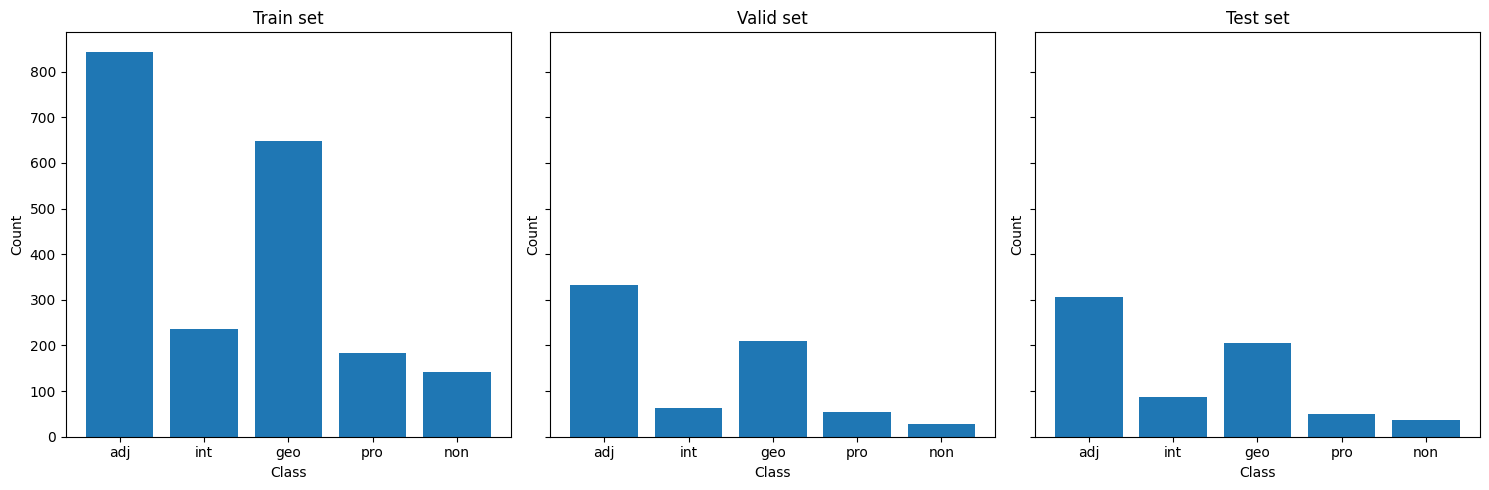

In [13]:
# Путь к базовой директории с разделенными данными
base_dir = 'split_dataset/'

# Определение имен классов
class_names = {
    0: 'adj',  # прилегающие дефекты
    1: 'int',  # дефекты целостности
    2: 'geo',  # дефекты геометрии
    3: 'pro',  # дефекты постобработки
    4: 'non'   # дефекты невыполнения
}

# Подсчет количества классов в каждой поддиректории
class_counts = count_classes(base_dir)

# Визуализация распределения классов
plot_class_distribution(class_counts, class_names)

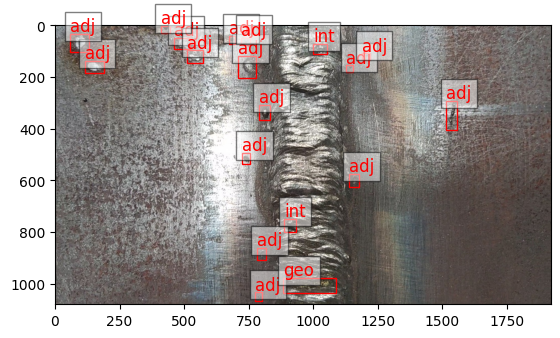

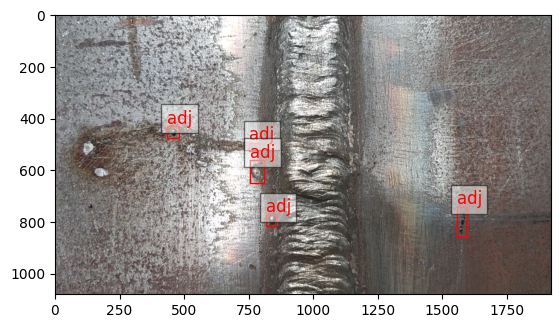

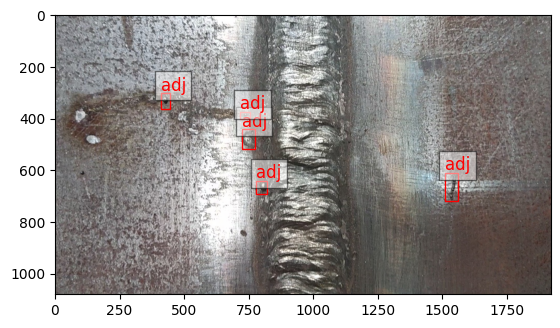

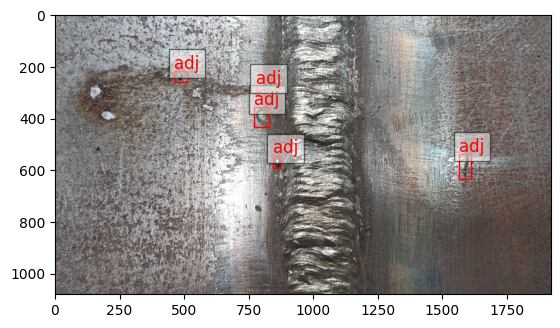

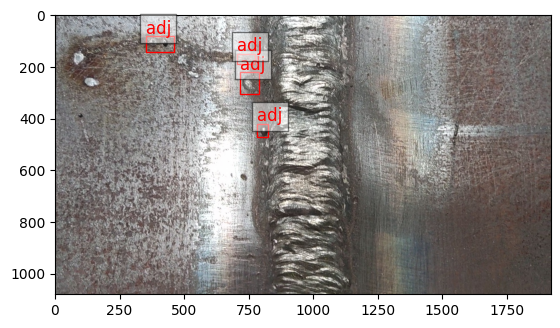

In [44]:
counter = 0
for image_file in image_files:
    image_path = os.path.join(data_dir, image_file)
    label_path = os.path.join(data_dir, os.path.splitext(image_file)[0] + '.txt')

    if os.path.exists(label_path):
        image = load_image(image_path)
        labels = load_labels(label_path)
        plot_image_with_labels(image, labels, class_names)
        counter += 1
        if counter >= 5:
            break
    else:
        print(f"No label file found for image {image_file}")

In [14]:
len(train_files), len(valid_files), len(test_files)

(696, 233, 233)

In [43]:
import cv2
import numpy as np
import os
import shutil

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def resize_and_pad(image, target_size=(640, 640)):
    h, w, _ = image.shape
    scale = min(target_size[0] / h, target_size[1] / w)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))

    h_resized, w_resized = resized_image.shape[:2]
    top_pad = (target_size[0] - h_resized) // 2
    bottom_pad = target_size[0] - h_resized - top_pad
    left_pad = (target_size[1] - w_resized) // 2
    right_pad = target_size[1] - w_resized - left_pad

    padded_image = cv2.copyMakeBorder(
        resized_image, top_pad, bottom_pad, left_pad, right_pad,
        borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )
    return padded_image

def create_resized_dirs(base_dir):
    for subset in ['train', 'valid', 'test']:
        subset_resized_dir = os.path.join(base_dir, f'{subset}_resized')
        create_dir(subset_resized_dir)
        create_dir(os.path.join(subset_resized_dir, 'images'))
        create_dir(os.path.join(subset_resized_dir, 'labels'))

def resize_images_and_save(base_dir, resized_base_dir, target_size=(512, 512)):
    for subset in ['train', 'valid', 'test']:
        subset_dir = os.path.join(base_dir, subset)
        image_dir = os.path.join(subset_dir, 'images')
        label_dir = os.path.join(subset_dir, 'labels')
        
        subset_resized_dir = os.path.join(resized_base_dir, f'{subset}_resized')
        resized_image_dir = os.path.join(subset_resized_dir, 'images')
        resized_label_dir = os.path.join(subset_resized_dir, 'labels')
        
        create_dir(resized_image_dir)
        create_dir(resized_label_dir)
        
        image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            resized_image_path = os.path.join(resized_image_dir, image_file)
            
            image = cv2.imread(image_path)
            if image is not None:
                padded_image = resize_and_pad(image, target_size)
                cv2.imwrite(resized_image_path, padded_image)
                
                # Копируем соответствующий файл разметки
                label_file = os.path.splitext(image_file)[0] + '.txt'
                src_label_path = os.path.join(label_dir, label_file)
                dst_label_path = os.path.join(resized_label_dir, label_file)
                if os.path.exists(src_label_path):
                    shutil.copy(src_label_path, dst_label_path)

# Путь к базовой директории с разделенными данными
base_dir = 'split_dataset/'
# Путь к директории для сохранения измененных изображений и разметок
resized_base_dir = 'split_dataset_resized/'

# Создание директорий для измененных изображений и разметок
create_resized_dirs(resized_base_dir)

# Изменение размера изображений и сохранение их в новые директории
resize_images_and_save(base_dir, resized_base_dir)



In [ ]:
# Путь к директории с изображениями и файлами разметки
image_dir = 'split_dataset_resized\test_resized\images'
labels_dir='split_dataset_resized\test_resized\labels'

# Путь к файлу с именами классов
class_names_file = 'dataset/classes.txt'

# Загрузка имен классов
class_names = load_class_names(class_names_file)

# Получение всех файлов из директории
images = os.listdir(image_dir)
labels = os.listdir(labels_dir)

# Фильтрация изображений и файлов разметки
image_files = [f for f in images if f.endswith(('.jpg', '.png', '.jpeg'))]
label_files = [f for f in labels if f.endswith('.txt')]

In [ ]:
# Пример загрузки и отображения одного изображения и его разметки
counter = 0
for image_file in image_files:
    image_path = os.path.join(data_dir, image_file)
    label_path = os.path.join(data_dir, os.path.splitext(image_file)[0] + '.txt')

    if os.path.exists(label_path):
        image = load_image(image_path)
        if image is not None:
            labels = load_labels(label_path)
            plot_image_with_labels(image, labels, class_names, image_file)
            counter += 1
            if counter >= 5:
                break
    else:
        print(f"No label file found for image {image_file}")

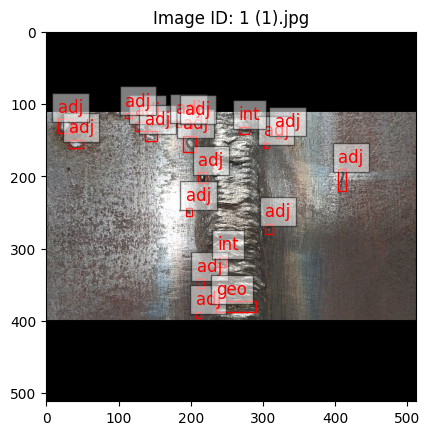

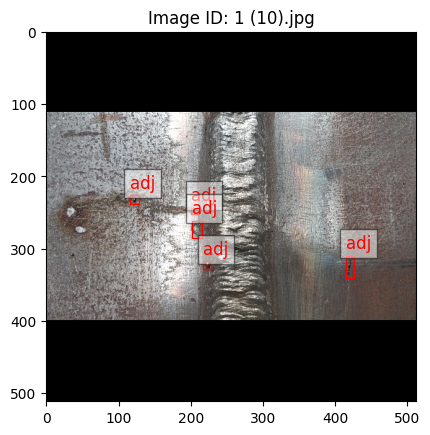

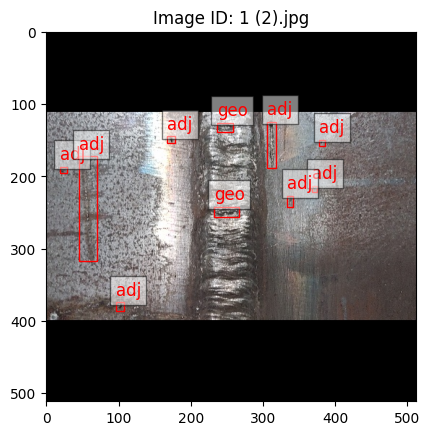

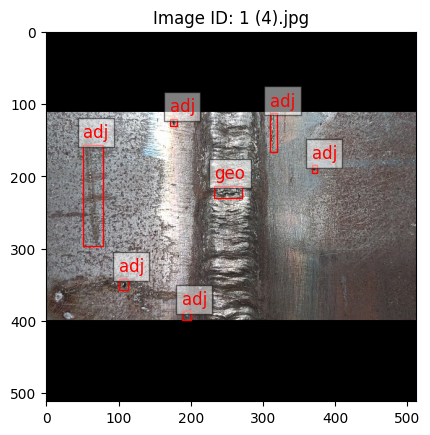

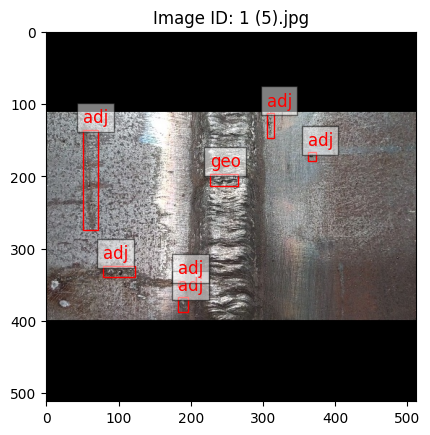

In [18]:
# Путь к директории с измененными изображениями и файлами разметки
base_resized_dir = 'split_dataset_resized/'

# Путь к файлу с именами классов
class_names_file = 'dataset/classes.txt'

# Загрузка имен классов
class_names = load_class_names(class_names_file)

# Поддиректории для train, valid и test
subsets = ['train_resized', 'valid_resized', 'test_resized']

# Пример загрузки и отображения одного изображения и его разметки
counter = 0
for subset in subsets:
    image_dir = os.path.join(base_resized_dir, subset, 'images')
    label_dir = os.path.join(base_resized_dir, subset, 'labels')
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

        if os.path.exists(label_path):
            image = load_image(image_path)
            if image is not None:
                labels = load_labels(label_path)
                plot_image_with_labels(image, labels, class_names, image_file)
                counter += 1
                if counter >= 5:
                    break
        else:
            print(f"No label file found for image {image_file}")
    if counter >= 5:
        break

In [16]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

def resize_and_pad(image, target_size=(512, 512)):
    h, w, _ = image.shape
    scale = min(target_size[0] / h, target_size[1] / w)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))

    h_resized, w_resized = resized_image.shape[:2]
    top_pad = (target_size[0] - h_resized) // 2
    bottom_pad = target_size[0] - h_resized - top_pad
    left_pad = (target_size[1] - w_resized) // 2
    right_pad = target_size[1] - w_resized - left_pad

    padded_image = cv2.copyMakeBorder(
        resized_image, top_pad, bottom_pad, left_pad, right_pad,
        borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0]
    )
    return padded_image, scale, left_pad, top_pad

def create_resized_dirs(base_dir):
    for subset in ['train', 'valid', 'test']:
        subset_resized_dir = os.path.join(base_dir, f'{subset}_resized')
        create_dir(subset_resized_dir)
        create_dir(os.path.join(subset_resized_dir, 'images'))
        create_dir(os.path.join(subset_resized_dir, 'labels'))

def resize_images_and_labels(base_dir, resized_base_dir, target_size=(640, 640)):
    for subset in ['train', 'valid', 'test']:
        subset_dir = os.path.join(base_dir, subset)
        image_dir = os.path.join(subset_dir, 'images')
        label_dir = os.path.join(subset_dir, 'labels')
        
        subset_resized_dir = os.path.join(resized_base_dir, f'{subset}_resized')
        resized_image_dir = os.path.join(subset_resized_dir, 'images')
        resized_label_dir = os.path.join(subset_resized_dir, 'labels')
        
        create_dir(resized_image_dir)
        create_dir(resized_label_dir)
        
        image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
        
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            resized_image_path = os.path.join(resized_image_dir, image_file)
            
            image = cv2.imread(image_path)
            if image is not None:
                if image.shape:
                    h, w, _ = image.shape
                    padded_image, scale, left_pad, top_pad = resize_and_pad(image, target_size)
                    cv2.imwrite(resized_image_path, padded_image)
                    
                    # Обновляем координаты bounding box'ов и сохраняем их
                    label_file = os.path.splitext(image_file)[0] + '.txt'
                    src_label_path = os.path.join(label_dir, label_file)
                    dst_label_path = os.path.join(resized_label_dir, label_file)
                    if os.path.exists(src_label_path):
                        with open(src_label_path, 'r') as file:
                            labels = file.readlines()
                        
                        with open(dst_label_path, 'w') as file:
                            for label in labels:
                                class_id, x_center, y_center, bbox_width, bbox_height = map(float, label.split())
                                # Преобразуем нормализованные координаты в абсолютные
                                x_center_abs = x_center * w
                                y_center_abs = y_center * h
                                bbox_width_abs = bbox_width * w
                                bbox_height_abs = bbox_height * h
                                
                                # Масштабируем координаты
                                x_center_abs = x_center_abs * scale + left_pad
                                y_center_abs = y_center_abs * scale + top_pad
                                bbox_width_abs *= scale
                                bbox_height_abs *= scale
                                
                                # Преобразуем обратно в нормализованные координаты
                                x_center = x_center_abs / target_size[1]
                                y_center = y_center_abs / target_size[0]
                                bbox_width = bbox_width_abs / target_size[1]
                                bbox_height = bbox_height_abs / target_size[0]
                                
                                file.write(f'{int(class_id)} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n')
                else:
                    print(f"Warning: Image shape is None for {image_file}")
            else:
                print(f"Error loading image {image_path}")

In [17]:
# Путь к базовой директории с разделенными данными
base_dir = 'split_dataset/'
# Путь к директории для сохранения измененных изображений и разметок
resized_base_dir = 'split_dataset_resized/'

# Создание директорий для измененных изображений и разметок
create_resized_dirs(resized_base_dir)

# Изменение размера изображений и обновление меток
resize_images_and_labels(base_dir, resized_base_dir)

In [19]:
import os
from PIL import Image
import shutil

# Define a function to resize the images
def resize_image(image_path, output_path, size=(512, 512)):
    with Image.open(image_path) as img:
        img = img.resize(size, Image.Resampling.LANCZOS)
        img.save(output_path)

# Define a function to process the dataset
def process_dataset(input_folder, output_folder, subfolders):
    for subfolder in subfolders:
        input_images_path = os.path.join(input_folder, subfolder, 'images')
        input_labels_path = os.path.join(input_folder, subfolder, 'labels')
        output_images_path = os.path.join(output_folder, subfolder + '_resized', 'images')
        output_labels_path = os.path.join(output_folder, subfolder + '_resized', 'labels')

        os.makedirs(output_images_path, exist_ok=True)
        os.makedirs(output_labels_path, exist_ok=True)

        for filename in os.listdir(input_images_path):
            if filename.endswith('.jpg') or filename.endswith('.png'):
                image_path = os.path.join(input_images_path, filename)
                label_path = os.path.join(input_labels_path, filename.replace('.jpg', '.txt').replace('.png', '.txt'))
                output_image_path = os.path.join(output_images_path, filename)
                output_label_path = os.path.join(output_labels_path, filename.replace('.jpg', '.txt').replace('.png', '.txt'))

                # Resize image and save
                resize_image(image_path, output_image_path)

                # Copy label file
                shutil.copy(label_path, output_label_path)
                
# Define the main function to run the processing
def main():
    input_folder = 'split_dataset'
    output_folder = 'split_dataset_resized_2'
    subfolders = ['test', 'train', 'valid']

    process_dataset(input_folder, output_folder, subfolders)

main()

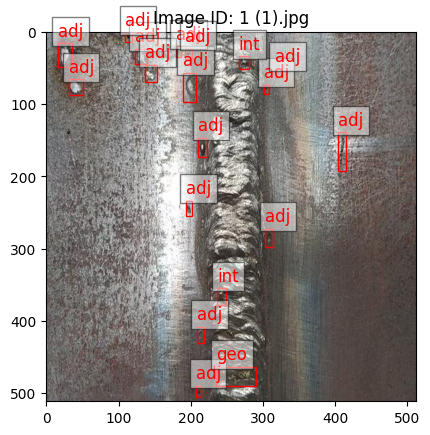

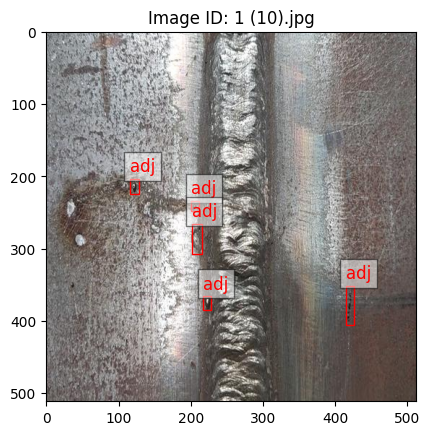

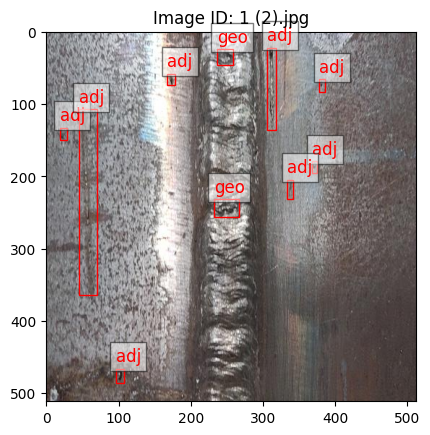

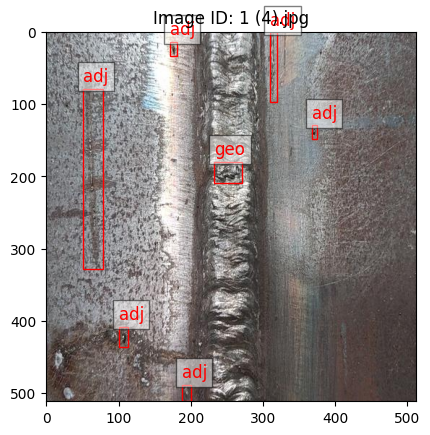

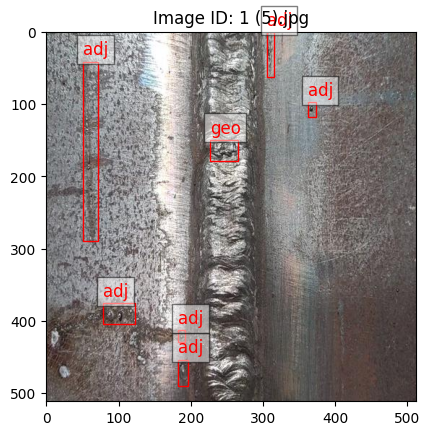

In [21]:
# Путь к директории с измененными изображениями и файлами разметки
base_resized_dir = 'split_dataset_resized_2/'

# Путь к файлу с именами классов
class_names_file = 'dataset/classes.txt'

# Загрузка имен классов
class_names = load_class_names(class_names_file)

# Поддиректории для train, valid и test
subsets = ['train_resized', 'valid_resized', 'test_resized']

# Пример загрузки и отображения одного изображения и его разметки
counter = 0
for subset in subsets:
    image_dir = os.path.join(base_resized_dir, subset, 'images')
    label_dir = os.path.join(base_resized_dir, subset, 'labels')
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        label_path = os.path.join(label_dir, os.path.splitext(image_file)[0] + '.txt')

        if os.path.exists(label_path):
            image = load_image(image_path)
            if image is not None:
                labels = load_labels(label_path)
                plot_image_with_labels(image, labels, class_names, image_file)
                counter += 1
                if counter >= 5:
                    break
        else:
            print(f"No label file found for image {image_file}")
    if counter >= 5:
        break